# Affine Network with compliant Crosslinkers - Angular Integration

- Notebook for efficient UMAT analysis and material parameter sensitivity studies.

In [1]:
!f2py -c -m umatpy2 py_anl_ai.f90 umat_anl_ai.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "umatpy2" sources
f2py options: []
f2py:> /tmp/tmpqg8lti25/src.linux-x86_64-3.6/umatpy2module.c
creating /tmp/tmpqg8lti25/src.linux-x86_64-3.6
Reading fortran codes...
	Reading file 'py_anl_ai.f90' (format:free)
{'before': '', 'this': 'use', 'after': ',intrinsic :: iso_fortran_env '}
Line #3 in py_anl_ai.f90:"use,intrinsic :: ISO_Fortran_env "
	analyzeline: Could not crack the use statement.
	Reading file 'aba_param.inc' (format:fix)
Line #15 in py_anl_ai.f90:"PARAMETER(NTENS = 6, NSTATEV = NSDV, NSHR=3) "
	determineexprtype: could not determine expressions ('nsdv') type.
analyzeline: Failed to evaluate 'nsdv'. Ignoring: name 'nsdv' is not defined
	Reading file 'umat_anl_ai.f90' (format:free)
Line #15 in umat_anl_ai.f90:"PAR

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from itertools import product

import umatpy2

In [3]:
base_dir = '/home/lpacheco/UMAT-ABAQUS_library/biofilaments/6_affine_network_linkers_ai'
os.chdir(base_dir)

In [4]:
tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

In [5]:
''' MATERIAL PROPERTIES '''

##### Penalty parameter (0) #####
K = 1000.0 # 1000.0
##### Isotropic matrix (1-3) #####
C10 = 0.0 # 0.0
C01 = 0.0 # 0.0
PHI = 1.0 # Filament volume fraction 1.0
###### Single Filament (4-11) #####
L = 1.96 # Filament contour length [microm] 1.96
R0F = 1.63 # Filament initial end-to-end distance [microm] 1.63
R0C = 0.014 # CL initial end-to-end distance [microm] 0.014
ETA = 0.6666 # CL stiffness [0,1] 0.6666
MU0 = 11111111111111111111111138600.0 # Stretch modulus [pN] inf
BETA = 0.5 # 0.5
B0 = 294.0*16.0*1.38e-5 # Bending stiffness (T*Lp*kb) [pN * microm**2] 294.0*16.0*1.38e-5
LAMBDA0 = 1.00 # Pre-stretch 1.00
##### Affine Network (12-13) #####
n = 7.66 # Isotropic filaments per unit volume [microm**-3] 7.66
B = 0.001 # Dispersion parameter 0.001

base_material_properties = [K,
    C10, C01, PHI,
    L, R0F, R0C, ETA, MU0, BETA, B0, LAMBDA0,
    n, B
]

mat_props_tex = ['$K$', '$C_{10}$', '$C_{01}$', '$\phi$', 
                 '$L$', '$r_{0,f}$', '$r_{0,c}$', '$\eta$', '$\mu_0$', '$\beta$', '$B_0$', '$\lambda_0$', 
                 '$n$', '$b$']

# Write material properties to a file
'''with open('material_properties.txt', 'w') as f:
    for prop in material_properties:
        f.write(f'{prop}\n')'''

"with open('material_properties.txt', 'w') as f:\n    for prop in material_properties:\n        f.write(f'{prop}\n')"

## Auxiliary Functions

In [6]:
''' AUX FUNCTIONS '''

# Setting the deformation gradient
def dfgrd(def_mode:str, stretch:float, ndim: int=3):
    '''Computes the deformation gradient F for simple deformation modes.
    INPUTS: def_mode - deformation mode ('U' uniaxial, 'SS(x/y)' simple shear along x/y directions)
            stretch/shear
    OUTPUTS: F - deformation gradient (3x3)'''
    F = np.eye((ndim))
    
    if def_mode == 'U':
        F[0,0] = stretch
        F[1,1] = 1/np.sqrt(stretch)
        F[2,2] = 1/np.sqrt(stretch)
    elif def_mode == 'SSx':
        F[0,1] = stretch
    elif def_mode == 'SSy':
        F[1,0] = stretch
    return F

# Function for sensitivity analysis
def sens_analysis(def_mode:str,
                  stretch: list, 
                  time: list, 
                  mat_props: list, id_props:list, range_props:dict, 
                  id_stress:int):
    ''' Performs a sensitivity analysis on the chosen parameters for the compliant CL actin network (material point).

    INPUTS: def_mode - deformation mode ('U' uniaxial, 'SS(x/y)' simple shear along x/y directions);
            stretch - [stretch_min, stretch_max, nsteps];
            time - [time_0, time_end, dtime];
            mat_props - list with the baseline material properties;
            id_props - indices of the material properties being studies in the array mat_props [i,j,k, ...];
            range_props - dict{'min':[imin, jmin, kmin...], 'max':[imax, jmax, kmax...], 'nstep':[int, int, int, ...]};
            id_stress - index of the target stress component [xx yy zz xy xz yz];

    OUTPUTS: stress - stress array as a function of given stretch values (i_n, j_n, k_n..., nsteps);
             map_props - array that maps each stress vector to the corresponding material properties being studied (i_n, j_n, k_n..., len(id_props))'''
    # List with all values for each property being studied
    sens_props, len_props, stress_flat = [], [], []
    stretch_arr = np.arange(stretch[0], stretch[1], (stretch[1]-stretch[0])/stretch[2])
    for i, _ in enumerate(id_props):
        aux_min = range_props['min'][i]
        aux_max = range_props['max'][i]
        aux_inc = range_props['nstep'][i]
        aux_list = np.linspace(aux_min, aux_max, aux_inc).tolist()
        len_props.append(len(aux_list))
        sens_props.append(aux_list)
    len_props.append(len(id_props))
    comb_props_flat = list(product(*sens_props))
    for i, comb in enumerate(comb_props_flat):
        kstep = 0
        aux_time, dtime = [time[0:2], time[2]]
        aux_stress = []
        for j, id in enumerate(id_props):
            mat_props[id] = comb[j]
        for k, stretch in enumerate(stretch_arr):
            kstep += k
            F = dfgrd(def_mode, stretch)
            stress = umatpy2.run_umat_py(mat_props, F, aux_time, dtime, kstep)
            aux_time[0] += dtime
            aux_stress.append(stress[id_stress])
        stress_flat.append(aux_stress)
    map_props = np.array(comb_props_flat).reshape(len_props)
    aux_shape = len_props[:-1]
    aux_shape.append(len(stretch_arr))
    stress_curves = np.array(stress_flat).reshape(aux_shape)
    return map_props, stress_curves


## Stress-Stretch curve 

Text(0, 0.5, '$\\sigma_{xx}$ (Pa)')

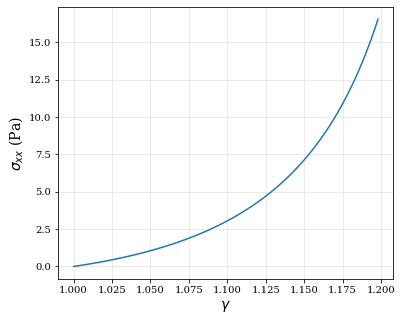

In [7]:
stretch_list, stress_list = [], []
material_properties = base_material_properties.copy()

stretch_initial = 1.0
stretch_max = 1.2
nsteps = 100
dstretch = (stretch_max-stretch_initial)/nsteps

time = [0, 0]
dtime=0.1
kstep=1

stress_array = np.zeros((1, nsteps))
time = [0, 0]
kstep=1
for j, stretch in enumerate(np.arange(stretch_initial, stretch_max, dstretch)):
    F = dfgrd('U', stretch)
    stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_array[0,j] = stress[0]
    time[0] += dtime
    kstep += 1
stretch_array = np.arange(stretch_initial, stretch_max, dstretch)
stress_array[0,:]

plt.figure(figsize=(6,5))
plt.plot(stretch_array, stress_array[0,:])
plt.grid(alpha=0.3)
plt.xlabel('$\gamma$', fontsize=14)
plt.ylabel('$\sigma_{xx}$ (Pa)', fontsize=14)

Comparison with material point results (in directory 'uniaxial_plots') obtained from anl_ai.f90. Just to check if python implementation is correct. All default values for material properties.

- Sensitivity analysis on: $\eta$ [0.4, 0.6, 0.8], $L$ [1.9,2.0,2.1] $\mu\mathrm{m}$, $r_{0,c}$ [10, 14, 18] nm and $r_{0,f}$ [1.4,1.55,1.7] $\mu\mathrm{m}$
- Deformation modes: uniaxial and simple shear

In [8]:
''' Read .out files'''
stretch_list, stress_list = [],[]

# Stretch
os.chdir('uniaxial_plots/L')
with open('uniaxial_1.out', 'r') as f:
    for line in f:
        _, stretch_val, _ = line.split()
        stretch_list.append(float(stretch_val))
os.chdir('..')
stretch_arr = np.array(stretch_list)

dirs = ['L', 'r0f', 'r0c', 'cl_stiffness']

for idir, dir in enumerate(dirs):
    os.chdir(dir)
    files = sorted(os.listdir())
    for ifile, file in enumerate(files):
        with open(file, 'r') as f:
            aux_stress = []
            for line in f:
                _, _, stress_val = line.split()
                aux_stress.append(float(stress_val))
        if ifile == 0:
            stress_arr = np.array(aux_stress)
        else:
            stress_arr = np.vstack((stress_arr, np.array(aux_stress)))
    stress_list.append(stress_arr)
    os.chdir('..')

stress_L_for, stress_r0f_for, stress_r0c_for, stress_eta_for = stress_list

print(stress_L_for.shape, stress_r0f_for.shape, stress_r0c_for.shape, stress_eta_for.shape)

os.chdir(base_dir)

(3, 100) (3, 100) (3, 100) (3, 100)


In [9]:
'''Run umat from python'''
material_properties = base_material_properties.copy()
stress_L_py = np.zeros((3,len(stretch_list)))
stress_r0f_py = np.zeros((3,len(stretch_list)))
stress_r0c_py = np.zeros((3,len(stretch_list)))
stress_eta_py = np.zeros((3,len(stretch_list)))

dtime=0.1

for i_L, l_aux in enumerate([1.9,2.0,2.1]):
    material_properties[4:8] = [l_aux, R0F, R0C, ETA]
    time = [0,0]
    for j, stretch in enumerate(stretch_list):
        kstep = j + 1
        F = dfgrd('U', stretch)
        stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_L_py[i_L,j] = stress[0]
        time[0] += dtime

for i_r0f, r0f_aux in enumerate([1.4,1.55,1.7]):
    material_properties[4:8] = [L, r0f_aux, R0C, ETA]
    time = [0,0]
    for j, stretch in enumerate(stretch_list):
        kstep = j + 1
        F = dfgrd('U', stretch)
        stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_r0f_py[i_r0f,j] = stress[0]
        time[0] += dtime

for i_r0c, r0c_aux in enumerate([0.01, 0.014, 0.018]):
    material_properties[4:8] = [L, R0F, r0c_aux, ETA]
    time = [0,0]
    for j, stretch in enumerate(stretch_list):
        kstep = j + 1
        F = dfgrd('U', stretch)
        stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_r0c_py[i_r0c,j] = stress[0]
        time[0] += dtime

for i_etac, etac in enumerate([0.4, 0.6, 0.8]):
    material_properties[4:8] = [L, R0F, R0C, etac]
    time = [0,0]
    for j, stretch in enumerate(stretch_list):
        kstep = j + 1
        F = dfgrd('U', stretch)
        stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_eta_py[i_etac,j] = stress[0]
        time[0] += dtime
material_properties[4:8] = [L, R0F, R0C, ETA]

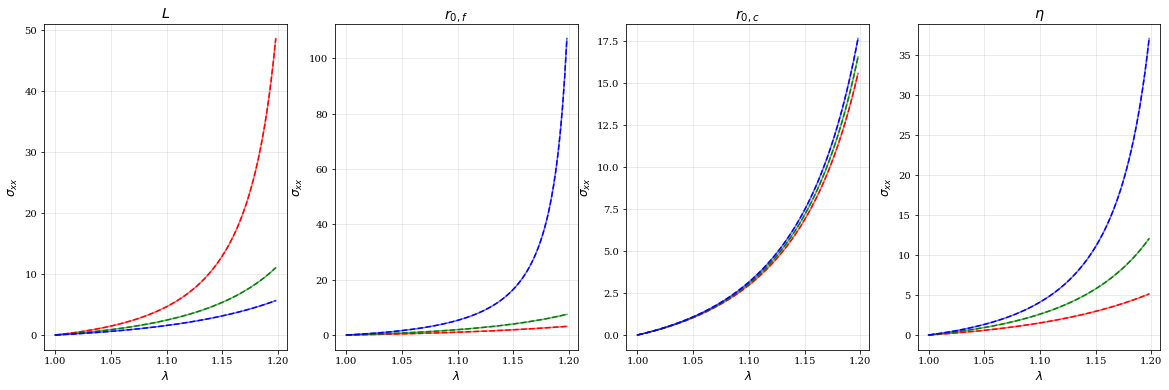

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6), sharex=True)
plt_clrs = ['r', 'g', 'b']

for i, l in enumerate([1.9,2.0,2.1]):
    axs[0].plot(stretch_arr, stress_L_py[i,:], linestyle='-', label=f'$L = $ {l:.2f}', color=plt_clrs[i], alpha=0.6)
    axs[0].plot(stretch_arr, stress_L_for[i,:], linestyle='--', color=plt_clrs[i])
    axs[0].set_title('$L$')

for i, r in enumerate([1.4,1.55,1.7]):
    axs[1].plot(stretch_arr, stress_r0f_py[i,:], linestyle='-', label='$r_{0,f}$' + f'$ = $ {r:.2f}', color=plt_clrs[i], alpha=0.6)
    axs[1].plot(stretch_arr, stress_r0f_for[i,:], linestyle='--', color=plt_clrs[i])
    axs[1].set_title('$r_{0,f}$')


for i, r in enumerate([0.01, 0.014, 0.018]):
    axs[2].plot(stretch_arr, stress_r0c_py[i,:], linestyle='-', label='$r_{0,c}$' + f'$ = $ {r:.3f}', color=plt_clrs[i], alpha=0.6)
    axs[2].plot(stretch_arr, stress_r0c_for[i,:], linestyle='--', color=plt_clrs[i])
    axs[2].set_title('$r_{0,c}$')

for i, r in enumerate([0.4, 0.6, 0.8]):
    axs[3].plot(stretch_arr, stress_eta_py[i,:], linestyle='-', label=f'$\eta = $ {r:.2f}', color=plt_clrs[i], alpha=0.6)
    axs[3].plot(stretch_arr, stress_eta_for[i,:], linestyle='--', color=plt_clrs[i])
    axs[3].set_title('$\eta$')

for ax in axs:
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$\sigma_{xx}$')
    ax.grid(True, alpha=0.3)


## Sensitivity analysis

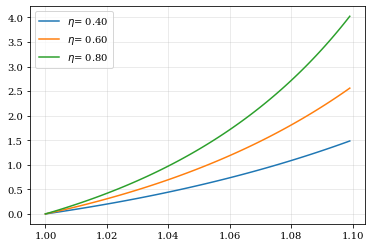

In [11]:
# Test if the sensitivity analysis function is working properly
material_properties = base_material_properties.copy()
'''range_dict = {'min':[1.96, 1.4, 0.01],
              'max':[2.16, 1.6, 0.014],
              'nstep':[3, 3, 3]}'''
range_dict = {'min':[0.4],
              'max':[0.8],
              'nstep':[3]}
map_array, curves = sens_analysis(def_mode='U', stretch=[1.0, 1.1, 100], time=[0,0,0.1], mat_props=material_properties, id_props=[7], range_props=range_dict, id_stress=0)
# print(map_array.shape, curves.shape)

# Sensitity analysis plots
for i in range(3):
    plt.plot(np.arange(1.0, 1.1, (1.1-1.0)/100), curves[i,:], label=mat_props_tex[7] + f'= {map_array[i].item():.2f}')
plt.grid(True, alpha=0.3)
plt.legend()

In [12]:
# Mean curves 

## Model Validation

Comparison with results from "An affine continuum mechanical model for cross-linked F-actin networks with compliant linker proteins" (Holzapfel, Unterberger and Ogden, 2014)

Text(0, 0.5, '$\\sigma_{xx}$ (Pa)')

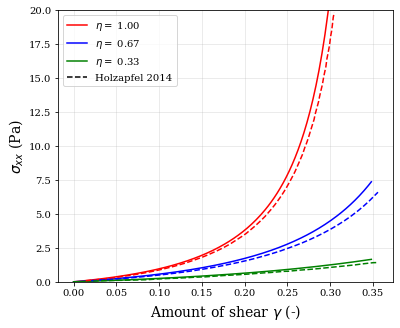

In [13]:
##### Normal stress vs Shear deformation (Figure 6a) #####
material_properties = base_material_properties.copy()
# Shear
shear_initial = 0
shear_max = 0.35
nsteps = 200
dshear = (shear_max-shear_initial)/nsteps
shear_array = np.arange(shear_initial, shear_max, dshear)
dtime = 0.1
# CL stiffness
etac_array = np.array([1, 2/3, 1/3])
# Stress
stress_array = np.zeros((len(etac_array), nsteps))
stress_array_2 = np.zeros((len(etac_array), nsteps))

for i, etac in enumerate(etac_array):
    material_properties[7] = etac
    time = [0,0]
    for j, shear in enumerate(shear_array):
        kstep = j + 1
        F = dfgrd('SSx', shear)
        stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_array[i,j] = stress[1]-stress[2]
        stress_array_2[i,j] = stress[2]
        time[0] += dtime

plt.figure(figsize=(6,5))
plt_colors = ['red', 'blue', 'green']
for i, eta in enumerate(etac_array):
    plt.plot(shear_array, stress_array[i,:], label=f'$\eta = $ {eta:.2f}', color=plt_colors[i])

files_6a = sorted([file for file in os.listdir('Holzapfel2014_plots') if '6a' in file], reverse=True)
os.chdir('Holzapfel2014_plots')
for j, file in enumerate(files_6a):
    df = pd.read_csv(file, header=None, names=['x', 'y'])
    eta = etac_array[j]
    plt.plot(df['x'], df['y'], color=plt_colors[j], linestyle='--')
os.chdir('..')
dashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim((0,20))
plt.xlabel('Amount of shear $\gamma$ (-)', fontsize=14)
plt.ylabel('$\sigma_{xx}$ (Pa)', fontsize=14)
#plt.savefig('00_fig2.pdf', bbox_inches='tight')

In [14]:
stress_array_2

array([[ 0.00000000e+00, -6.88557462e-03, -1.38958606e-02,
        -2.10327104e-02, -2.82995880e-02, -3.56971862e-02,
        -4.32293840e-02, -5.08984654e-02, -5.87055257e-02,
        -6.66556322e-02, -7.47477968e-02, -8.29868922e-02,
        -9.13759738e-02, -9.99163097e-02, -1.08612893e-01,
        -1.17466176e-01, -1.26479770e-01, -1.35656975e-01,
        -1.45001802e-01, -1.54515099e-01, -1.64201488e-01,
        -1.74066599e-01, -1.84109639e-01, -1.94335813e-01,
        -2.04748769e-01, -2.15352082e-01, -2.26150037e-01,
        -2.37146588e-01, -2.48344043e-01, -2.59746564e-01,
        -2.71360425e-01, -2.83188807e-01, -2.95234037e-01,
        -3.07502574e-01, -3.19998589e-01, -3.32727272e-01,
        -3.45693681e-01, -3.58899906e-01, -3.72354548e-01,
        -3.86059059e-01, -4.00023395e-01, -4.14248531e-01,
        -4.28742877e-01, -4.43510723e-01, -4.58558392e-01,
        -4.73891588e-01, -4.89516819e-01, -5.05440756e-01,
        -5.21669560e-01, -5.38209469e-01, -5.55068556e-0

Text(0, 0.5, '$\\sigma_{xy}$ (Pa)')

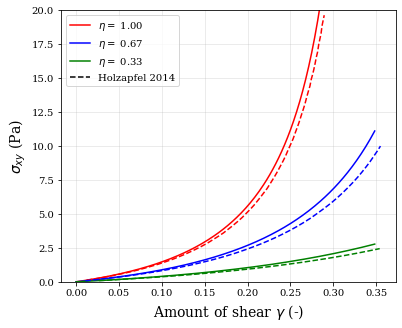

In [15]:
##### Shear stress vs Shear deformation (Figure 6b) #####
material_properties = base_material_properties.copy()
# Shear
shear_initial = 0
shear_max = 0.35
nsteps = 200
dshear = (shear_max-shear_initial)/nsteps
shear_array = np.arange(shear_initial, shear_max, dshear)
dtime = 0.1
# CL stiffness
etac_array = np.array([1, 2/3, 1/3])
# Stress
stress_array = np.zeros((len(etac_array), nsteps))


for i, etac in enumerate(etac_array):
    material_properties[7] = etac
    time = [0,0]
    for j, shear in enumerate(shear_array):
        kstep = j + 1
        F = dfgrd('SSx', shear)
        stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
        stress_array[i,j] = stress[3]
        time[0] += dtime

plt.figure(figsize=(6,5))
plt_colors = ['red', 'blue', 'green']
for i, eta in enumerate(etac_array):
    plt.plot(shear_array, stress_array[i,:], label=f'$\eta = $ {eta:.2f}', color=plt_colors[i])

files_6a = sorted([file for file in os.listdir('Holzapfel2014_plots') if '6b' in file], reverse=True)
os.chdir('Holzapfel2014_plots')
for j, file in enumerate(files_6a):
    df = pd.read_csv(file, header=None, names=['x', 'y'])
    eta = etac_array[j]
    plt.plot(df['x'], df['y'], color=plt_colors[j], linestyle='--')
os.chdir('..')
dashed_line = plt.plot([], [], color='black', linestyle='--', label='Holzapfel 2014')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim((0,20))
plt.xlabel('Amount of shear $\gamma$ (-)', fontsize=14)
plt.ylabel('$\sigma_{xy}$ (Pa)', fontsize=14)

## Studying different contributions (AN and IM)

- Study the contribution of the Affine Network (AN), Non-affine Network (NA - not implemented) and Isotropic Ground-Substance/Matrix (IM)
- AN is only considered when the density of contractile bundles/isotropic filaments $n$>0.
- IM is only considered when the filament volume fraction $\varphi$<1.

In [16]:
# Common variables
stretch_array = np.linspace(1., 1.2, 200)
shear_array = np.linspace(0., 0.35, 200)
time = [0, 0]
dtime = 0.1

##### AN contribution #####
material_properties_AN = base_material_properties.copy()
stress_AN_uni, stress_AN_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy2.run_umat_py(material_properties_AN, F, time, dtime, kstep)
    stress_AN_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy2.run_umat_py(material_properties_AN, F, time, dtime, kstep)
    stress_AN_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_AN_uni = np.array(stress_AN_uni)
stress_AN_shear = np.array(stress_AN_shear)

print(stress_AN_uni.shape, stress_AN_shear.shape)

(200,) (200,)


In [17]:
# IM contribution
material_properties_IM = base_material_properties.copy()
material_properties_IM[1:4] = [3.5, 2, 0.5]
material_properties_IM[12] = 0
stress_IM_uni, stress_IM_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy2.run_umat_py(material_properties_IM, F, time, dtime, kstep)
    stress_IM_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy2.run_umat_py(material_properties_IM, F, time, dtime, kstep)
    stress_IM_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_IM_uni = np.array(stress_IM_uni)
stress_IM_shear = np.array(stress_IM_shear)

print(stress_IM_uni.shape, stress_IM_shear.shape)

(200,) (200,)


In [18]:
# Sum of separate/isolated contributions
stress_sum_uni = stress_AN_uni + stress_IM_uni
stress_sum_shear = stress_AN_shear + stress_IM_shear

# Running the UMAT considering both AN and IM contributions
material_properties = base_material_properties.copy()
material_properties[1:4] = [3.5, 2, 0.5]
stress_uni, stress_shear = [], [] 

for i, stretch in enumerate(stretch_array):
    kstep = i + 1
    F = dfgrd('U', stretch)
    stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_uni.append(stress[0])
    time[0] = (i+1)*dtime

for j, shear in enumerate(shear_array):
    kstep = j + 1
    F = dfgrd('SSx', shear)
    stress = umatpy2.run_umat_py(material_properties, F, time, dtime, kstep)
    stress_shear.append(stress[3])
    time[0] = (j+1)*dtime

stress_uni = np.array(stress_uni)
stress_shear = np.array(stress_shear)

print(stress_uni.shape, stress_shear.shape)

(200,) (200,)


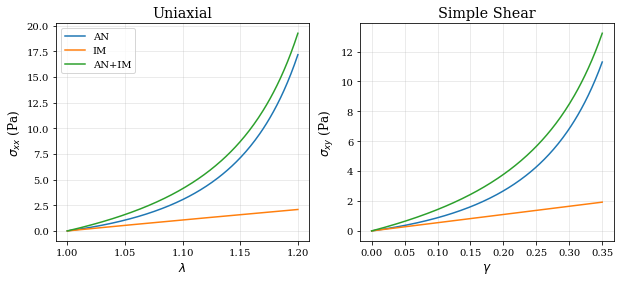

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(stretch_array, stress_AN_uni, label = 'AN')
axs[0].plot(stretch_array, stress_IM_uni, label = 'IM')
axs[0].plot(stretch_array, stress_uni, label = 'AN+IM')
axs[0].set_xlabel('$\lambda$')
axs[0].set_ylabel('$\sigma_{xx}$ (Pa)')
axs[0].set_title('Uniaxial')
axs[0].legend()

axs[1].plot(shear_array, stress_AN_shear, label = 'AN')
axs[1].plot(shear_array, stress_IM_shear, label = 'IM')
axs[1].plot(shear_array, stress_shear, label = 'AN+IM')
axs[1].set_xlabel('$\gamma$')
axs[1].set_ylabel('$\sigma_{xy}$ (Pa)')
axs[1].set_title('Simple Shear')

for ax in axs:
    ax.grid(True, alpha=0.3)

In [20]:
print(np.all(stress_sum_uni - stress_uni <= abs(1e-12)))
print(np.all(stress_sum_shear - stress_shear <= abs(1e-15)))

True
True


In [21]:
# !gfortran -o 00_test.o 00_test.f90
# !./00_test.o

In [22]:
# Getting the outputs with subprocess
# result = subprocess.run("./00_new_anl_ai.o", shell=True, stdout=subprocess.PIPE)
# Get the output from the completed process
# fortran_output = result.stdout.decode("utf-8")
# Process the Fortran output as needed
# num_output = [float(out) for out in fortran_output.split()]
# stretch = num_output[0]
# stress = np.array(num_output[1:7])
# ddsdde = np.array(num_output[7:])
